**AI-POWERED FRAUD DETECTION SYSTEM**

Build an AI-Powered Fraud Detection System capable of identifying fraudulent
transactions in real-time, leveraging innovative machine learning approaches to minimize
false positives and maximize the detection of actual fraud.

**Data Preprocessing**

Shape of dataset: (535178, 10)

Data types:
 step             int64
customer        object
age             object
gender          object
zipcodeOri      object
merchant        object
zipMerchant     object
category        object
amount         float64
fraud            int64
dtype: object

Missing values:
 step           0
customer       0
age            0
gender         0
zipcodeOri     0
merchant       0
zipMerchant    0
category       0
amount         0
fraud          0
dtype: int64


,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,11,'C1760492708','1','F','28007','M1823072687','28007','es_transportation',52.35,0
1,172,'C1222389110','3','M','28007','M1823072687','28007','es_transportation',14.75,0
2,106,'C879949041','3','F','28007','M1823072687','28007','es_transportation',3.73,0
3,86,'C409740988','5','M','28007','M1823072687','28007','es_transportation',61.42,0
4,152,'C671449181','3','F','28007','M692898500','28007','es_health',9.05,0



Unique value counts per column:

step: 180
customer: 4112
age: 8
gender: 4
zipcodeOri: 1
merchant: 50
zipMerchant: 1
category: 15
amount: 22796
fraud: 2

Fraud label distribution:
fraud
0    0.987869
1    0.012131
Name: proportion, dtype: float64


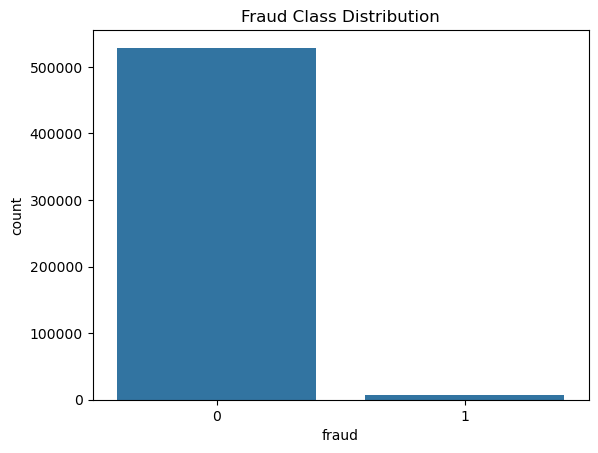

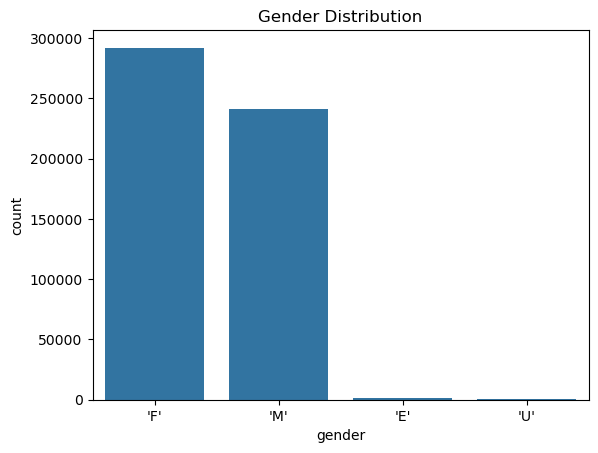

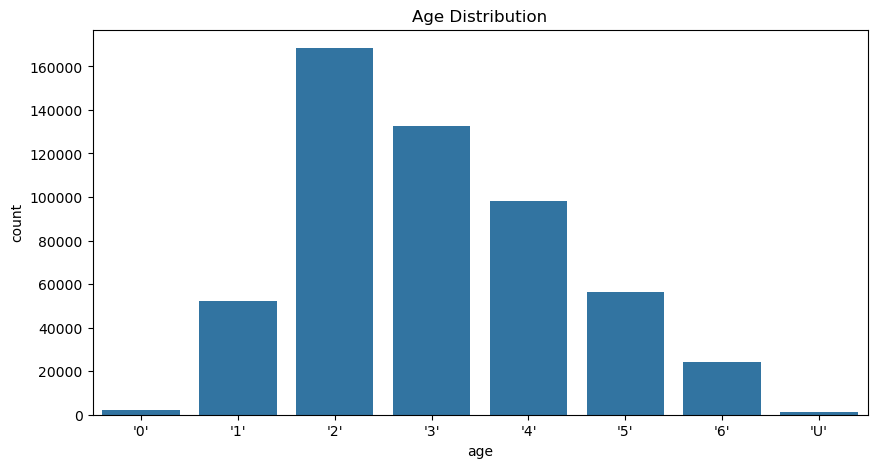

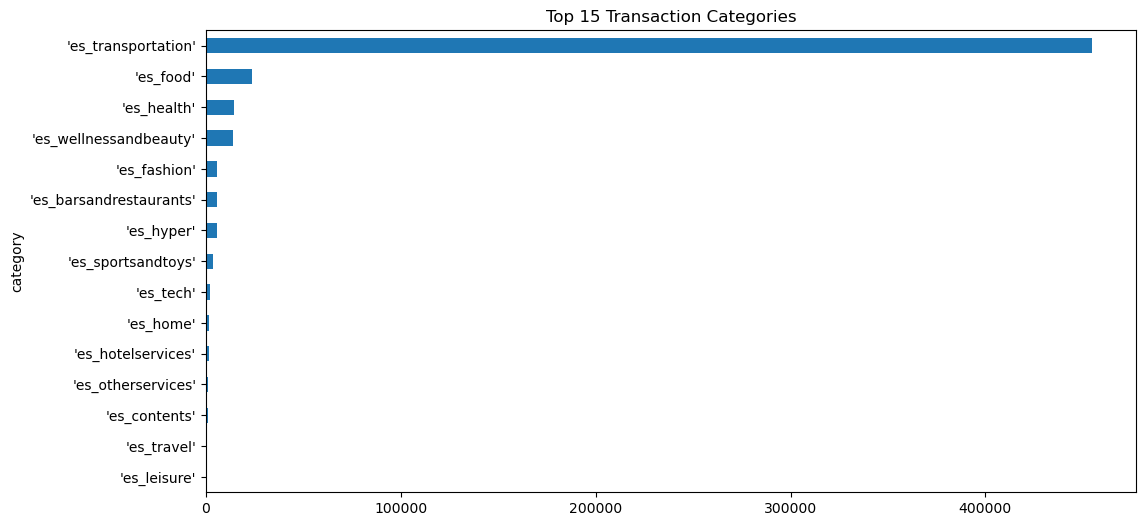

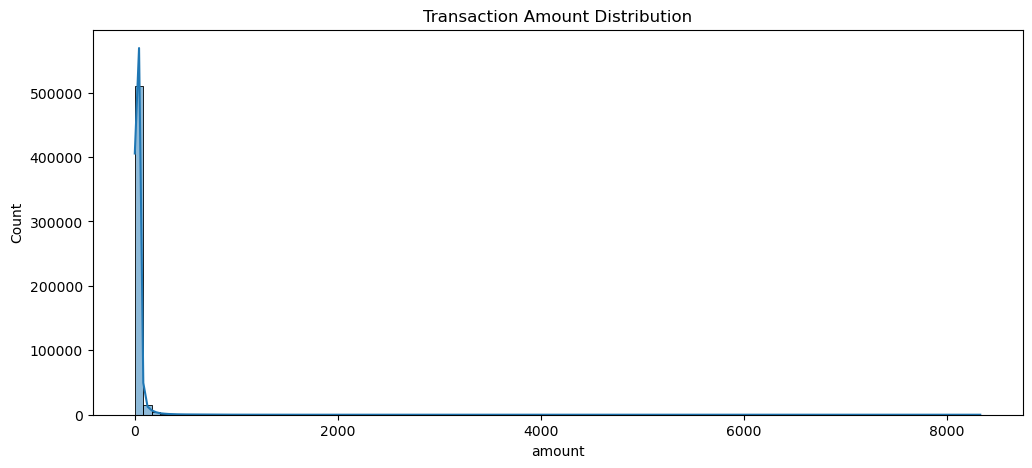

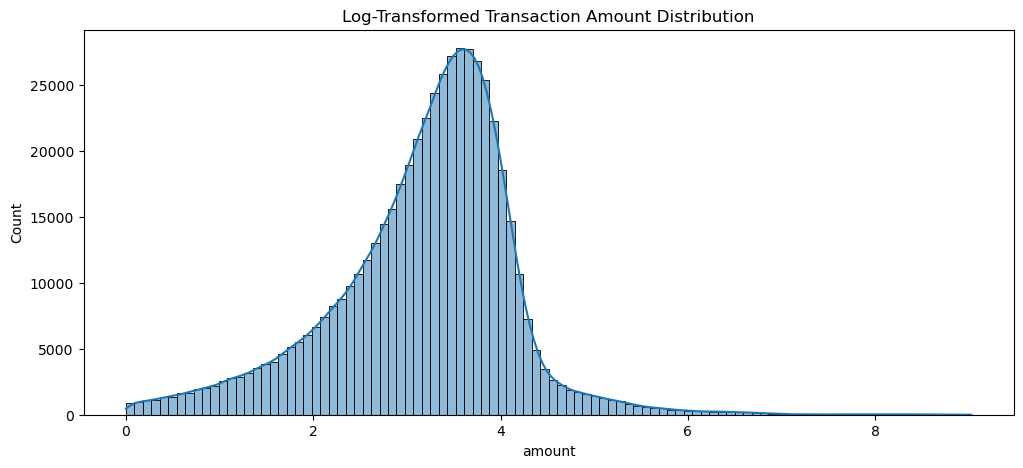

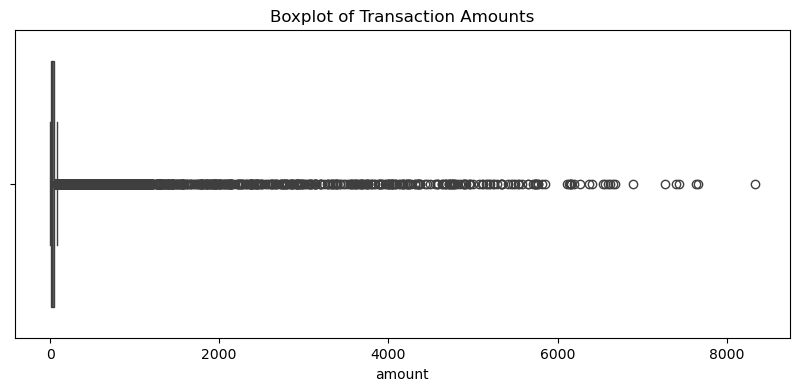

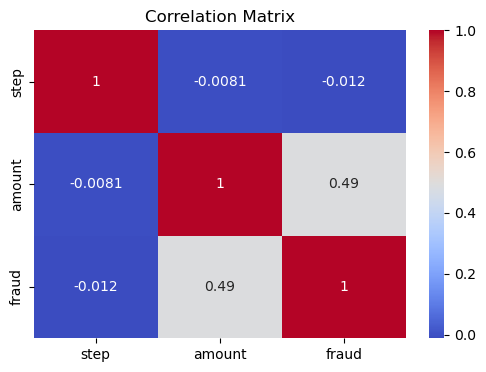

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("D:/SEM-7/HSBC/Datasets/Dataset.csv")


print("Shape of dataset:", df.shape)
print("\nData types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())
display(df.head())


print("\nUnique value counts per column:\n")
for col in df.columns:
    print(f"{col}: {df[col].nunique()}")


print("\nFraud label distribution:")
print(df["fraud"].value_counts(normalize=True)) 
sns.countplot(x="fraud", data=df)
plt.title("Fraud Class Distribution")
plt.show()


sns.countplot(x="gender", data=df)
plt.title("Gender Distribution")
plt.show()


plt.figure(figsize=(10,5))
sns.countplot(x="age", data=df, order=sorted(df["age"].unique()))
plt.title("Age Distribution")
plt.show()


plt.figure(figsize=(12,6))
df["category"].value_counts().nlargest(15).plot(kind="barh")
plt.title("Top 15 Transaction Categories")
plt.gca().invert_yaxis()
plt.show()


plt.figure(figsize=(12,5))
sns.histplot(df["amount"], bins=100, kde=True)
plt.title("Transaction Amount Distribution")
plt.show()


plt.figure(figsize=(12,5))
sns.histplot(np.log1p(df["amount"]), bins=100, kde=True)
plt.title("Log-Transformed Transaction Amount Distribution")
plt.show()


plt.figure(figsize=(10,4))
sns.boxplot(x=df["amount"])
plt.title("Boxplot of Transaction Amounts")
plt.show()


plt.figure(figsize=(6,4))
sns.heatmap(df[["step", "amount", "fraud"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


| Feature       | Observation                                                           |
| ------------- | --------------------------------------------------------------------- |
| `fraud`       | Highly imbalanced (1.2% fraud cases) → needs handling before training |
| `zipcodeOri`  | Only 1 unique value → likely **not useful so drop it**                           |
| `zipMerchant` | Only 1 unique value → likely **drop**                                 |
| `gender`      | Has noise values like `'E'`, `'U'` → need to **clean**                |
| `category`    | Strong skew toward `'es_transportation'` → may affect model learning  |
| `merchant`    | Only 50 unique → might be useful if encoded well                      |
| `customer`    | High cardinality (4112) → possibly drop or encode meaningfully        |


# Fraud Detection Project: Data Preprocessing and Feature Engineering

This document outlines the steps involved in cleaning, preprocessing, and engineering features for the fraud detection dataset. The goal is to prepare the data for training a robust machine learning model.

## 1. Clean & Preprocess Data

Before any modeling can begin, the raw data needs to be cleaned and transformed into a suitable format.

### 1.1 Drop Non-Informative Columns

The following columns are considered non-informative for our analysis and will be dropped to reduce dimensionality and potential noise:

- `zipcodeOri`: Original zipcode of the transaction.
- `zipMerchant`: Zipcode of the merchant.

These columns are often constant or have too many unique values to provide meaningful insights into fraud patterns.

### 1.2 Clean Categorical Values

Categorical columns need to be standardized and consistent to avoid issues during encoding.

- `gender`: This column will be inspected for inconsistencies (e.g., 'M', 'm', 'Male', 'F', 'f', 'Female') and standardized to a consistent format (e.g., 'M', 'F'). Any other unexpected values will be handled (e.g., set to a default, 'U' for unknown, or removed if negligible).

### 1.3 Encode Categorical Features

Categorical features must be converted into numerical representations that machine learning models can understand.

- `category`: This column represents the type of transaction. It will be encoded using either **One-Hot Encoding** (if the number of unique categories is manageable and no ordinal relationship exists) or **Label Encoding** (if there's a large number of categories or a perceived ordinality, though for categories, One-Hot is usually preferred).
- `gender`: After cleaning, this column will be **Label Encoded** as it has a small, fixed number of categories.
- `merchant`: Given the likely large number of unique merchants, **Label Encoding** or a similar technique (e.g., Target Encoding if careful cross-validation is used to avoid data leakage) might be more practical than One-Hot Encoding to avoid creating a very sparse dataset.

## 2. Handle Class Imbalance

Fraud detection datasets are typically highly imbalanced, with a much smaller number of fraudulent transactions compared to legitimate ones. This imbalance can lead to models that perform poorly on the minority class (fraud).

To address this, we will explore the following techniques:

- **Oversampling Minority Class with SMOTE (Synthetic Minority Over-sampling Technique):** SMOTE generates synthetic samples of the minority class, helping to balance the dataset. This should be applied *only* on the training data to avoid data leakage.
- **Undersampling Majority Class:** Randomly removing samples from the majority class to match the minority class. This can lead to loss of information from the majority class and is generally less preferred than oversampling or class-weighted models unless computational resources are a significant constraint.
- **Class-Weighted Models:** Utilizing machine learning models that can inherently handle class imbalance by assigning different weights to the classes during training. Popular choices include:
    - **XGBoost (eXtreme Gradient Boosting):** Offers a `scale_pos_weight` parameter to give more importance to the positive (fraud) class.
    - **LightGBM (Light Gradient Boosting Machine):** Also provides a `scale_pos_weight` parameter for the same purpose.

The choice between these methods (or a combination) will depend on experimental results and model performance.

## 3. Feature Engineering

Creating new features from existing ones can significantly improve model performance by providing more discriminative information.

- **`amount_log`:** The natural logarithm of the transaction `amount`. This can help in handling skewed distributions of the `amount` feature and reduce the impact of outliers.
    - Formula: $amount_{log} = \log(1 + \text{amount})$ (using `log1p` to handle cases where amount might be zero)
- **`amount_per_step`:** The transaction `amount` divided by the `step` (which represents time). This could capture transaction density or intensity over time.
    - Formula: $amount_{per\_step} = \text{amount} / \text{step}$
- **Frequency Encodings:**
    - **Transactions per Customer:** Counting the number of transactions made by each unique customer (`customer` ID). This can help identify customers with unusually high or low transaction volumes.
    - **Transactions per Merchant:** Counting the number of transactions processed by each unique `merchant` ID. This can help identify merchants with suspicious transaction activity.

## 4. Split Data

Before training, the data needs to be split into training and testing sets to evaluate model generalization performance.

- **Train-Test Split (Stratified on Fraud):** This is the primary splitting strategy. It ensures that both the training and testing sets maintain the same proportion of fraudulent transactions as the original dataset. This is crucial for imbalanced datasets.
- **Time-Based Split (if `step` is sequential time):** If the `step` column genuinely represents sequential time (e.g., days, hours), a time-based split is highly recommended. This involves training on data up to a certain `step` value and testing on data from subsequent `step` values. This better simulates a real-world scenario where the model needs to predict future fraud.

In [2]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

# Drop useless columns
df = df.drop(columns=["zipcodeOri", "zipMerchant"])

# Clean and encode 'gender'
df['gender'] = df['gender'].str.replace("'", "")                    # Remove single quotes
df['gender'] = df['gender'].replace(['E', 'U'], 'Unknown')          # Replace invalid values
gender_map = {'F': 0, 'M': 1, 'Unknown': 2}
df['gender'] = df['gender'].map(gender_map)                         # Manual encoding

# Clean 'age' column
df['age'] = df['age'].astype(str).str.replace("'", "")              # Remove single quotes
df['age'] = df['age'].replace(['U', '0'], pd.NA)                    # Replace invalid values with NaN
df['age'] = pd.to_numeric(df['age'], errors='coerce')              # Convert to numeric
median_age = int(df['age'].median())                               # Compute median
df['age'] = df['age'].fillna(median_age).astype(int)               # Fill NaNs and cast to int
print("Cleaned age column:\n", df['age'].head())

# Encode categorical features
label_enc = LabelEncoder()
df["category"] = label_enc.fit_transform(df["category"])
df["merchant"] = label_enc.fit_transform(df["merchant"])

# Add engineered features
df["amount_log"] = np.log1p(df["amount"])
df["amount_per_step"] = df["amount"] / (df["step"] + 1)

# Drop high-cardinality or ID columns
df = df.drop(columns=["customer"])

# Save cleaned dataframe
df_cleaned = df.copy()
print("\nDataFrame info:")
print(df_cleaned.info())

# Optional: Save to CSV
df_cleaned.to_csv('cleaned_dataframe-2.csv', index=False)


Cleaned age column:
 0    1
1    3
2    3
3    5
4    3
Name: age, dtype: int32

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 535178 entries, 0 to 535177
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   step             535178 non-null  int64  
 1   age              535178 non-null  int32  
 2   gender           535178 non-null  int64  
 3   merchant         535178 non-null  int32  
 4   category         535178 non-null  int32  
 5   amount           535178 non-null  float64
 6   fraud            535178 non-null  int64  
 7   amount_log       535178 non-null  float64
 8   amount_per_step  535178 non-null  float64
dtypes: float64(3), int32(3), int64(3)
memory usage: 30.6 MB
None


In [3]:
df_cleaned.head()

,step,age,gender,merchant,category,amount,fraud,amount_log,amount_per_step
0,11,1,0,18,12,52.35,0,3.976874,4.362500
1,172,3,1,18,12,14.75,0,2.756840,0.085260
2,106,3,0,18,12,3.73,0,1.553925,0.034860
3,86,5,1,18,12,61.42,0,4.133886,0.705977
4,152,3,0,39,4,9.05,0,2.307573,0.059150


In [4]:
pip install xgboost imbalanced-learn scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Check total missing values per column
missing_values = df_cleaned.isnull().sum()

# Filter only columns that have NaNs
missing_columns = missing_values[missing_values > 0]

# Show the columns with missing values
print("🧯 Columns with NaN values:\n")
print(missing_columns)


🧯 Columns with NaN values:

Series([], dtype: int64)


**SMOTE-Enhanced XGBoost Classifier**

In [7]:
pip install shap

  Using cached cloudpickle-3.1.1-py3-none-any.whl.metadata (7.1 kB)
Using cached cloudpickle-3.1.1-py3-none-any.whl (20 kB)
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 2.6/2.6 MB 15.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/28.1 MB ? eta -:--:--
   ----- ---------------------------------- 3.9/28.1 MB 19.5 MB/s eta 0:00:02
   ----------- ---------------------------- 8.4/28.1 MB 20.8 MB/s eta 0:00:01
   ------------------ --------------------- 12.8/28.1 MB 20.6 MB/s eta 0:00:01
   ------------------------ --------------- 17.0/28.1 MB 20.6 MB/s eta 0:00:01
   ------------------------------ --------- 21.2/28.1 MB 20.6 MB/s eta 0:00:01
   ------------------------------------ --- 25.7/28.1 MB 20.6 MB/s eta 0:00:01
   ---------------------------------------- 28.1/28.1 MB 19.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


✅ After SMOTE:
 fraud
0    422948
1    422948
Name: count, dtype: int64


[15:36:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    105738
           1       0.49      0.93      0.64      1298

    accuracy                           0.99    107036
   macro avg       0.74      0.96      0.82    107036
weighted avg       0.99      0.99      0.99    107036


📉 Confusion Matrix:
[[104478   1260]
 [    88   1210]]
🎯 F1 Score: 0.6423
🚀 AUC-ROC Score: 0.9967
📦 Model Size: 2.07 MB
⚡ Inference Time (1 sample): 0.043000 seconds


100%|===================| 107026/107036 [39:01<00:00]        


📈 SHAP Feature Importance:


The figure layout has changed to tight


✅ Global SHAP summary plot saved as 'shap_summary_plot.png'


The figure layout has changed to tight


✅ SHAP local explanation (sample 0) saved as 'shap_waterfall_0.png'


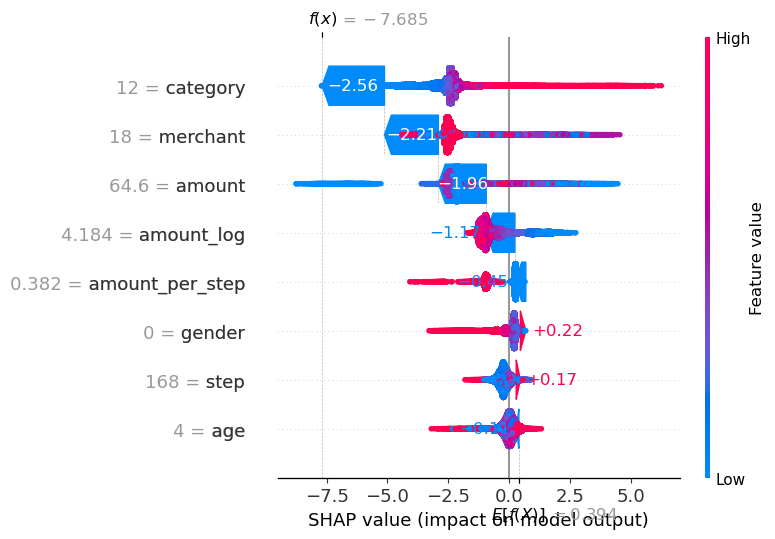

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import joblib
import os
import time
import shap
import matplotlib.pyplot as plt

# -----------------------------
# 1. Prepare Data
# -----------------------------
X = df_cleaned.drop(columns=['fraud'])
y = df_cleaned['fraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# -----------------------------
# 2. Apply SMOTE
# -----------------------------
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("✅ After SMOTE:\n", pd.Series(y_train_bal).value_counts())

# -----------------------------
# 3. Train XGBoost
# -----------------------------
xgb = XGBClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42
)

xgb.fit(X_train_bal, y_train_bal)

# -----------------------------
# 4. Predictions and Evaluation
# -----------------------------
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("\n📉 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("🎯 F1 Score:", round(f1_score(y_test, y_pred), 4))
print("🚀 AUC-ROC Score:", round(roc_auc_score(y_test, y_proba), 4))

# -----------------------------
# 5. Model Efficiency: Size and Inference Time
# -----------------------------
joblib.dump(xgb, "xgb_smote_model.pkl")
model_size_mb = os.path.getsize("xgb_smote_model.pkl") / 1024 / 1024
print(f"📦 Model Size: {model_size_mb:.2f} MB")

sample = X_test.iloc[[0]]
start = time.time()
xgb.predict(sample)
latency = time.time() - start
print(f"⚡ Inference Time (1 sample): {latency:.6f} seconds")

# -----------------------------
# 6. Explainability using SHAP
# -----------------------------
explainer = shap.Explainer(xgb, X_train_bal)
shap_values = explainer(X_test)

# Global feature importance
print("\n📈 SHAP Feature Importance:")
shap.summary_plot(shap_values, X_test, show=False)
plt.tight_layout()
plt.savefig("shap_summary_plot.png")  # Save for report or Streamlit
print("✅ Global SHAP summary plot saved as 'shap_summary_plot.png'")

# Explain one prediction (optional)
shap.plots.waterfall(shap_values[0], show=False)
plt.tight_layout()
plt.savefig("shap_waterfall_0.png")
print("✅ SHAP local explanation (sample 0) saved as 'shap_waterfall_0.png'")


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


X = df_cleaned.drop(columns=['fraud'])
y = df_cleaned['fraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)


smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
print("✅ After SMOTE:\n", pd.Series(y_train_bal).value_counts())


xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42
)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)

meta_model = LogisticRegression(max_iter=1000)


stack_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('rf', rf_model)
    ],
    final_estimator=meta_model,
    passthrough=True, 
    cv=5,
    n_jobs=-1
)

stack_model.fit(X_train_bal, y_train_bal)


y_pred = stack_model.predict(X_test)
y_proba = stack_model.predict_proba(X_test)[:, 1]

print("\n📊 Classification Report (Stacking):")
print(classification_report(y_test, y_pred))

print("\n📉 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("🎯 F1 Score:", round(f1_score(y_test, y_pred), 4))
print("🚀 AUC-ROC Score:", round(roc_auc_score(y_test, y_proba), 4))


✅ After SMOTE:
 fraud
0    422948
1    422948
Name: count, dtype: int64

📊 Classification Report (Stacking):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    105738
           1       0.46      0.94      0.61      1298

    accuracy                           0.99    107036
   macro avg       0.73      0.96      0.80    107036
weighted avg       0.99      0.99      0.99    107036


📉 Confusion Matrix:
[[104288   1450]
 [    84   1214]]
🎯 F1 Score: 0.6128
🚀 AUC-ROC Score: 0.9945


A. Oversampling Methods

**SMOTE**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier


X = df_cleaned.drop(columns=['fraud'])
y = df_cleaned['fraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)


smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
print("✅ After SMOTE:\n", pd.Series(y_train_bal).value_counts())


xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42
)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)


mlp_meta_model = MLPClassifier(
    hidden_layer_sizes=(32, 16),  # two layers: 32 → 16
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42
)


stack_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('rf', rf_model)
    ],
    final_estimator=mlp_meta_model,
    passthrough=True,  # meta-model gets original features too
    cv=5,
    n_jobs=-1
)

stack_model.fit(X_train_bal, y_train_bal)

y_pred = stack_model.predict(X_test)
y_proba = stack_model.predict_proba(X_test)[:, 1]

print("\n📊 Classification Report (MLP Meta):")
print(classification_report(y_test, y_pred))

print("\n📉 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("🎯 F1 Score:", round(f1_score(y_test, y_pred), 4))
print("🚀 AUC-ROC Score:", round(roc_auc_score(y_test, y_proba), 4))


import joblib

joblib.dump(stack_model, 'smote_MLP.pkl')
print("\n✅ Model saved as 'smote_MLP.pkl'")



✅ After SMOTE:
 fraud
0    422948
1    422948
Name: count, dtype: int64

📊 Classification Report (MLP Meta):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    105738
           1       0.58      0.90      0.70      1298

    accuracy                           0.99    107036
   macro avg       0.79      0.94      0.85    107036
weighted avg       0.99      0.99      0.99    107036


📉 Confusion Matrix:
[[104889    849]
 [   133   1165]]
🎯 F1 Score: 0.7035
🚀 AUC-ROC Score: 0.9948

✅ Model saved as 'smote_MLP.pkl'


B. Undersampling Methods 

**Random Undersampling**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
import joblib 

X = df_cleaned.drop(columns=['fraud'])
y = df_cleaned['fraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)


undersampler = RandomUnderSampler(random_state=42)
X_train_bal, y_train_bal = undersampler.fit_resample(X_train, y_train)

print("✅ After Undersampling:\n", pd.Series(y_train_bal).value_counts())


xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42
)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)


mlp_meta_model = MLPClassifier(
    hidden_layer_sizes=(32, 16),
    activation='relu',
    solver='adam',
    max_iter=1500,
    random_state=42
)


stack_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('rf', rf_model)
    ],
    final_estimator=mlp_meta_model,
    passthrough=True,
    cv=5,
    n_jobs=-1
)

stack_model.fit(X_train_bal, y_train_bal)


y_pred = stack_model.predict(X_test)
y_proba = stack_model.predict_proba(X_test)[:, 1]

print("\n📊 Classification Report (MLP Meta):")
print(classification_report(y_test, y_pred))

print("\n📉 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("🎯 F1 Score:", round(f1_score(y_test, y_pred), 4))
print("🚀 AUC-ROC Score:", round(roc_auc_score(y_test, y_proba), 4))


joblib.dump(stack_model, 'stack_model.pkl')
print("\n✅ Model saved as 'stack_model.pkl'")


✅ After Undersampling:
 fraud
0    5194
1    5194
Name: count, dtype: int64

📊 Classification Report (MLP Meta):
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    105738
           1       0.26      0.98      0.40      1298

    accuracy                           0.97    107036
   macro avg       0.63      0.97      0.69    107036
weighted avg       0.99      0.97      0.97    107036


📉 Confusion Matrix:
[[102018   3720]
 [    24   1274]]
🎯 F1 Score: 0.405
🚀 AUC-ROC Score: 0.996

✅ Model saved as 'stack_model.pkl'
